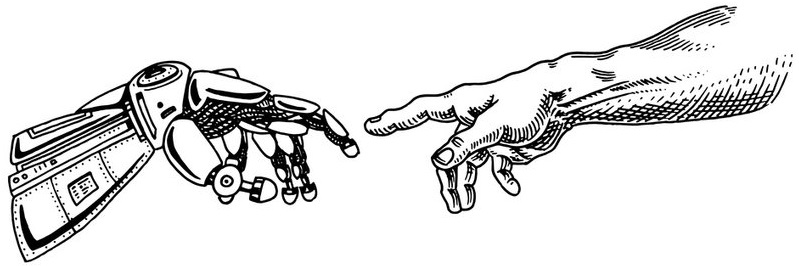

## Imports and load the data

In [1]:
import numpy as np
import pandas as pd
import os
import time
import sys
import glob
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.ensemble import VotingClassifier,AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
Sync = []
Spontan = []
Alone = []
loc = r'D:\T'
def Makedf(location):
    for cs in os.listdir(location):
        if cs.endswith('Sync.csv'):
            Sync.append(os.path.join(r'D:\T', cs))
        elif cs.endswith('Alone.csv'):
            Alone.append(os.path.join(r'D:\T', cs))
        elif cs.endswith('Spontan.csv'):
            Spontan.append(os.path.join(r'D:\T', cs))
Makedf(loc)

In [3]:
DF_Sync = pd.DataFrame()
for file in Sync:
    df = pd.read_csv(file)
    DF_Sync = pd.concat([DF_Sync,df], axis=0, ignore_index=True)
DF_Spot = pd.DataFrame()
for file in Spontan:
    df = pd.read_csv(file)
    DF_Spot = pd.concat([DF_Spot,df], axis=0, ignore_index=True)
DF_Alone = pd.DataFrame()
for file in Alone:
    df = pd.read_csv(file)
    DF_Alone = pd.concat([DF_Alone,df], axis=0, ignore_index=True)

In [4]:
def RemoveSevenSecond(df):
    df.drop(df[df.Time < df.head(1)["Time"][0]+7].index, inplace=True)

In [5]:
def RemoveHands(df, hands):
    df.drop(df[df[' # hands'] == hands].index,inplace = True)

In [6]:
def RemoveType(df, direction):
    df.drop(df[df[' Hand Type'] == direction].index,inplace = True)

In [7]:
def RefreshData(df):
    df.dropna(inplace = True)
    df.reset_index(drop=True, inplace = True)
    df.sort_index(inplace=True)

In [8]:
def MergeR(df):
    df.set_index(' Hand Type', inplace=True)
    df_Right = df.loc[['right']].reset_index()
    df_Left = df.loc[['left']].reset_index()
    df_final = pd.merge(df_Right, df_Left, left_index=True, right_index=True, how='outer')
    return df_final

In [9]:
def RenameCol(df, OldName):
    temp = OldName
    if OldName[1] == " ":
        OldName = '\''+ OldName[1:]
    if OldName.isspace():
        OldName.replace(" ", "_", 1)
    df = df.rename(columns={temp : OldName}, inplace=True)

In [10]:
DF_Sync.shape, DF_Alone.shape, DF_Spot.shape

((76019, 22), (38822, 22), (76121, 22))

In [11]:
DF_Sync.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,427.2310,139071,right,2,69.65445,209.9525,-18.54797,-65.04708,338.2631,-102.57630,...,-0.763543,112.1363,162.7645,10.928120,275.1779,-7.356547,87.30630,0.0,0.059833,0.0
1,427.2310,139071,left,2,-87.18215,204.5752,-40.50642,171.17460,247.9453,-96.48488,...,1.220096,-137.3886,158.1433,-27.829490,-261.8767,-47.873840,30.62584,0.0,0.000000,0.0
2,427.2483,139073,right,2,68.97833,215.1191,-20.12599,-44.44045,302.9170,-83.93305,...,-0.766907,111.5590,167.9522,9.239409,272.0606,-5.603438,83.23297,0.0,0.090605,0.0
3,427.2483,139073,left,2,-85.20093,209.7387,-41.18375,70.93041,344.8777,-46.40427,...,1.276068,-135.5462,162.8801,-30.982930,-259.9806,-43.469070,26.40578,0.0,0.000000,0.0
4,427.2641,139075,right,2,68.11068,220.9579,-21.77186,-22.08052,307.0574,-67.08289,...,-0.767062,110.1764,173.1205,7.244619,267.7276,-2.693964,82.23973,0.0,0.069295,0.0


In [12]:
DF_Spot.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,335.9984,128556,right,2,128.63570,224.0294,-12.29588,-18.26243,-140.54450,-117.57790,...,-1.588251,177.5125,173.5658,-14.569630,276.8753,-33.68264,91.61740,0.0,1.250576,0.0
1,335.9984,128556,left,2,-93.24845,143.9423,-37.81597,-109.09820,240.38980,-67.62959,...,0.873458,-147.0455,109.9380,-5.326688,-329.8577,-34.41571,93.88171,0.0,0.014736,0.0
2,336.0150,128558,right,2,129.15550,221.9923,-15.00181,47.36464,-64.25022,-168.85850,...,-1.528183,177.7894,171.1952,-14.677850,276.0645,-33.15913,97.88171,0.0,1.069930,0.0
3,336.0150,128558,left,2,-94.86554,148.5542,-39.00158,-80.99012,278.60220,-66.79356,...,0.879703,-148.2022,113.0909,-7.375025,-326.9279,-39.97873,85.98000,0.0,0.000000,0.0
4,336.0315,128560,right,2,129.87070,220.7944,-18.38681,35.05422,-84.74242,-205.72030,...,-1.461710,178.3730,169.9159,-15.246240,276.1767,-30.72506,104.13920,0.0,0.916969,0.0


In [13]:
DF_Alone.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,518.8087,149620,left,1,-97.60160,164.1213,42.81255,104.2589,-491.6730,-55.42755,...,1.661706,-166.7207,164.8320,27.58547,-378.1662,65.89330,-69.90282,0.0,0.741855,0.0
1,518.8252,149622,left,1,-95.78062,157.6353,42.18084,148.9683,-351.7386,-36.32422,...,1.623222,-165.4907,155.6419,29.71037,-380.3233,52.92441,-55.71872,0.0,0.827916,0.0
2,518.8418,149623,left,1,-94.39360,154.6338,41.93171,161.6958,-349.9117,-29.04277,...,1.602898,-164.3658,151.5701,31.05059,-381.7444,48.55032,-47.27909,0.0,0.920401,0.0
3,518.8587,149625,left,1,-92.02553,150.6723,42.10119,117.3475,-187.1781,24.42598,...,1.567605,-162.2663,144.6214,33.94577,-383.4688,40.27151,-30.72728,0.0,1.034603,0.0
4,518.8749,149627,left,1,-89.31953,148.1826,42.67065,155.3344,-135.6337,35.87055,...,1.535920,-159.4586,138.6087,36.68195,-381.0906,29.07133,-17.01065,0.0,1.166705,0.0


In [14]:
DF_Alone.isna().sum()

Time               0
 Frame ID          0
 Hand Type         0
 # hands           0
 Position X        0
 Position Y        0
 Position Z        0
 Velocity X        0
 Velocity Y        0
 Velocity Z        0
 Pitch             0
 Roll              0
 Yaw               0
 Wrist Pos X       0
 Wrist Pos Y       0
 Wrist Pos Z       0
 Elbow pos X       0
 Elbow Pos Y       0
 Elbow Pos Z       0
 Grab Strenth      0
 Grab Angle        0
 Pinch Strength    0
dtype: int64

In [15]:
DF_Alone[' Hand Type'].value_counts()

left     37663
right     1159
Name:  Hand Type, dtype: int64

In [16]:
DF_Alone[' # hands'].value_counts()

1    37814
2     1008
Name:  # hands, dtype: int64

In [17]:
RemoveHands(DF_Alone,2)

In [18]:
DF_Alone[' # hands'].value_counts()

1    37814
Name:  # hands, dtype: int64

In [19]:
DF_Alone[' Hand Type'].value_counts()

left     37159
right      655
Name:  Hand Type, dtype: int64

In [20]:
RemoveType(DF_Alone, 'right')

In [21]:
DF_Alone[' Hand Type'].value_counts()

left    37159
Name:  Hand Type, dtype: int64

In [22]:
RemoveSevenSecond(DF_Alone)

In [23]:
RefreshData(DF_Alone)

In [24]:
DF_Alone.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,525.8185,150428,left,1,-52.96039,184.5535,-2.856696,162.15270,127.60520,-85.83782,...,1.199751,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.0,0.073635,0.0
1,525.8351,150430,left,1,-50.04434,185.5024,-4.845364,102.82480,-24.84337,-79.46504,...,1.171960,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.0,0.018766,0.0
2,525.8516,150432,left,1,-49.07749,182.2930,-6.442950,12.12360,-258.75260,-99.40902,...,1.152816,-94.32024,128.7403,2.742160,-322.1467,20.402740,-2.617105,0.0,0.018409,0.0
3,525.8682,150434,left,1,-50.89614,176.7708,-9.005262,-53.57292,-271.01500,-143.03330,...,1.114818,-99.72611,127.6519,5.047988,-331.5826,28.883190,-7.521224,0.0,0.149852,0.0
4,525.8848,150436,left,1,-51.76074,174.1853,-10.600340,-40.95883,-140.44390,-59.85620,...,1.091361,-102.66840,128.2257,6.734126,-333.9562,27.848030,-3.312394,0.0,0.242324,0.0


In [25]:
DF_Sync.isna().sum()

Time               0
 Frame ID          0
 Hand Type         0
 # hands           0
 Position X        0
 Position Y        0
 Position Z        0
 Velocity X        0
 Velocity Y        0
 Velocity Z        0
 Pitch             0
 Roll              0
 Yaw               0
 Wrist Pos X       0
 Wrist Pos Y       0
 Wrist Pos Z       0
 Elbow pos X       0
 Elbow Pos Y       0
 Elbow Pos Z       0
 Grab Strenth      0
 Grab Angle        0
 Pinch Strength    0
dtype: int64

In [26]:
DF_Sync[' Hand Type'].value_counts()

right    38365
left     37654
Name:  Hand Type, dtype: int64

In [27]:
DF_Sync[' # hands'].value_counts()

2    75278
1      741
Name:  # hands, dtype: int64

In [28]:
RemoveHands(DF_Sync,1)

In [29]:
DF_Sync[' # hands'].value_counts()

2    75278
Name:  # hands, dtype: int64

In [30]:
DF_Sync[' Hand Type'].value_counts()

left     37639
right    37639
Name:  Hand Type, dtype: int64

In [31]:
RemoveSevenSecond(DF_Sync)

In [32]:
RefreshData(DF_Sync)

In [33]:
DF_Sync.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,434.2387,139878,right,2,121.96880,230.3867,61.91891,7.82505,-222.59100,121.9149,...,-0.320716,143.0681,170.9626,92.10286,290.9513,-17.46554,156.27410,0.0,0.036538,0.0
1,434.2387,139878,left,2,-80.92312,284.2069,29.01107,84.47700,-45.59256,134.2085,...,0.624079,-107.3702,221.7536,46.12994,-254.8560,22.47225,40.89467,0.0,0.000000,0.0
2,434.2553,139880,right,2,121.61940,226.1235,64.10963,-32.32643,-248.08270,109.7341,...,-0.333641,143.3853,166.9691,94.34527,293.7114,-20.13464,156.68940,0.0,0.001488,0.0
3,434.2553,139880,left,2,-79.71033,282.4789,31.69110,55.75132,-119.51820,158.4537,...,0.653397,-106.8187,220.1253,48.09507,-258.4003,23.92692,43.43317,0.0,0.000000,0.0
4,434.2718,139882,right,2,121.03880,222.2049,65.98412,-28.86916,-210.96420,109.7062,...,-0.344350,143.3656,163.3614,96.39383,296.6688,-21.13594,159.25370,0.0,0.000000,0.0


In [34]:
DF_Spot.isna().sum()

Time               0
 Frame ID          0
 Hand Type         0
 # hands           0
 Position X        0
 Position Y        0
 Position Z        0
 Velocity X        0
 Velocity Y        0
 Velocity Z        0
 Pitch             0
 Roll              0
 Yaw               0
 Wrist Pos X       0
 Wrist Pos Y       0
 Wrist Pos Z       0
 Elbow pos X       0
 Elbow Pos Y       0
 Elbow Pos Z       0
 Grab Strenth      0
 Grab Angle        0
 Pinch Strength    0
dtype: int64

In [35]:
DF_Spot[' Hand Type'].value_counts()

right    38106
left     38015
Name:  Hand Type, dtype: int64

In [36]:
DF_Spot[' # hands'].value_counts()

2    75310
1      811
Name:  # hands, dtype: int64

In [37]:
RemoveHands(DF_Spot,1)

In [38]:
DF_Spot[' Hand Type'].value_counts()

left     37655
right    37655
Name:  Hand Type, dtype: int64

In [39]:
RemoveSevenSecond(DF_Spot)

In [40]:
RefreshData(DF_Spot)

In [41]:
DF_Spot.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,343.0061,129364,right,2,152.3135,204.6813,-39.256710,-28.56766,23.00662,8.315823,...,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.709900,1.0,2.793122,0.329752
1,343.0061,129364,left,2,-102.2870,198.3166,-2.122641,-174.57210,379.14680,28.479910,...,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.000000
2,343.0227,129365,right,2,151.8334,204.4899,-39.084380,-54.05849,-21.54555,19.405560,...,-0.560823,190.8670,170.1528,9.191355,323.1941,20.16283,161.858900,1.0,2.704073,0.293775
3,343.0227,129365,left,2,-103.8721,201.4944,-2.063620,-178.50250,357.85480,6.646493,...,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.000000
4,343.0392,129367,right,2,151.4056,203.4883,-38.142800,-14.11075,-56.44812,68.092860,...,-0.554623,190.4547,169.7302,10.512530,324.1130,19.09524,161.374600,1.0,2.422549,0.175940


In [42]:
RightHand = pd.read_csv('D:/extraFiles/HandRight.csv')

In [43]:
RightHand.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.67167,226.2064,20.26470,34.26665,-195.214700,-35.043020,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.24119,222.9389,20.11781,36.16443,-180.093900,-4.052799,...,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.72461,220.9709,19.94972,26.35298,-95.088190,-11.157620,...,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.09016,219.7124,19.67679,19.46804,-61.755180,-21.303780,...,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.46017,219.3652,19.13128,21.94964,-8.355943,-35.081790,...,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0


In [44]:
RightHand.isna().any()

Time               False
 Frame ID          False
 Hand Type         False
 # hands           False
 Position X        False
 Position Y        False
 Position Z        False
 Velocity X        False
 Velocity Y        False
 Velocity Z        False
 Pitch             False
 Roll              False
 Yaw               False
 Wrist Pos X        True
 Wrist Pos Y        True
 Wrist Pos Z        True
 Elbow pos X        True
 Elbow Pos Y        True
 Elbow Pos Z        True
 Grab Strenth      False
 Grab Angle        False
 Pinch Strength    False
dtype: bool

In [45]:
RightHand[' Hand Type'].value_counts()

right    4738
left       74
Name:  Hand Type, dtype: int64

In [46]:
RightHand[' # hands'].value_counts()

1    4732
2      80
Name:  # hands, dtype: int64

In [47]:
RemoveHands(RightHand,2)

In [48]:
RightHand[' # hands'].value_counts()

1    4732
Name:  # hands, dtype: int64

In [49]:
RightHand[' Hand Type'].value_counts()

right    4698
left       34
Name:  Hand Type, dtype: int64

In [50]:
RemoveType(RightHand, 'left')

In [51]:
RightHand[' Hand Type'].value_counts()

right    4698
Name:  Hand Type, dtype: int64

In [52]:
RemoveSevenSecond(RightHand)

In [53]:
RefreshData(RightHand)

In [54]:
RightHand.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,135.3024,16287,right,1,11.93032,199.9861,4.981665,-35.512210,-165.3466,-57.68153,...,-0.906612,75.45740,206.0521,45.38764,284.3946,140.0167,201.9318,0.0,0.561324,0.0
1,135.3194,16289,right,1,11.19190,195.3075,3.661716,-43.587440,-309.8374,-77.18515,...,-0.904311,74.46141,202.4562,44.28679,282.6278,140.9712,203.6773,0.0,0.626321,0.0
2,135.3357,16291,right,1,10.53308,189.0297,2.829388,-30.403600,-363.0033,-43.79815,...,-0.901862,73.60060,197.4387,43.54082,280.6384,142.5401,206.7526,0.0,0.636596,0.0
3,135.3524,16293,right,1,10.24300,181.9816,2.064330,-15.424000,-423.2120,-43.99948,...,-0.901268,73.19537,191.7202,42.73155,279.7357,148.1382,209.9330,0.0,0.701644,0.0
4,135.3690,16295,right,1,10.02061,174.8592,1.228467,-8.733602,-413.4513,-53.88054,...,-0.897777,72.68671,186.1613,41.98006,278.6890,152.5215,212.1112,0.0,0.786548,0.0


In [56]:
DF_Sync.shape

(65828, 22)

In [57]:
DF_Sync = MergeR(DF_Sync)

In [70]:
DF_Sync.drop([' Hand Type_x'], axis=1, inplace = True)

In [71]:
DF_Sync

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,434.2387,139878,2,121.96880,230.3867,61.91891,7.82505,-222.59100,121.9149,0.959785,...,0.624079,-107.3702,221.7536,46.12994,-254.8560,22.472250,40.89467,0.0,0.0,0.0
1,434.2553,139880,2,121.61940,226.1235,64.10963,-32.32643,-248.08270,109.7341,0.956199,...,0.653397,-106.8187,220.1253,48.09507,-258.4003,23.926920,43.43317,0.0,0.0,0.0
2,434.2718,139882,2,121.03880,222.2049,65.98412,-28.86916,-210.96420,109.7062,0.951746,...,0.683048,-106.3970,217.4241,50.26434,-262.3120,24.761910,42.24427,0.0,0.0,0.0
3,434.2884,139884,2,120.60720,219.1105,67.75517,-18.53857,-156.22400,112.2314,0.944151,...,0.709288,-105.9420,213.8663,52.21570,-271.2896,29.791380,35.81071,0.0,0.0,0.0
4,434.3050,139885,2,120.41840,217.8251,68.88145,-22.01035,-149.86140,131.3148,0.932912,...,0.731741,-105.8699,212.5583,53.02802,-275.5691,32.855700,32.98580,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32909,856.1965,67304,2,97.75611,205.9629,30.04651,28.36298,77.44335,162.1428,0.909181,...,0.429763,-107.8500,127.8215,32.85250,-318.7630,20.751860,138.01250,0.0,0.0,0.0
32910,856.2291,67306,2,98.93275,208.3153,34.85991,44.38393,71.36857,187.5408,0.983621,...,0.434664,-108.0805,128.1729,33.40391,-314.6744,14.308990,139.99090,0.0,0.0,0.0
32911,856.2631,67309,2,101.91230,212.0264,42.53568,79.95810,113.41030,190.7714,1.065334,...,0.456099,-109.0018,129.5246,33.89856,-304.9600,-0.548136,142.01090,0.0,0.0,0.0
32912,856.2958,67311,2,103.84750,214.7484,47.07082,61.11773,95.13531,155.7453,1.110287,...,0.459446,-109.7250,130.7078,34.03360,-295.5957,-14.978170,140.02630,0.0,0.0,0.0


In [60]:
DF_Spot.shape

(65972, 22)

In [61]:
DF_Spot = MergeR(DF_Spot)

In [68]:
DF_Spot.drop([' Hand Type_x'], axis=1, inplace = True)

In [69]:
DF_Spot

,Time_x,Frame ID_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,343.0061,129364,2,152.3135,204.6813,-39.25671,-28.56766,23.006620,8.315823,0.654996,...,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.000000,1.870325,0.000000
1,343.0227,129365,2,151.8334,204.4899,-39.08438,-54.05849,-21.545550,19.405560,0.652891,...,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.000000,1.851572,0.000000
2,343.0392,129367,2,151.4056,203.4883,-38.14280,-14.11075,-56.448120,68.092860,0.637780,...,1.496526,-168.4939,174.6985,-3.134404,-316.4541,-28.81729,-1.155143,0.000000,1.865896,0.000000
3,343.0558,129369,2,151.6132,202.9217,-37.08601,21.48209,-21.234860,51.146260,0.608950,...,1.499930,-170.1878,179.6781,-4.185746,-315.3597,-25.78214,-9.287997,0.000000,1.899355,0.000000
4,343.0723,129371,2,152.4920,202.8671,-36.85715,57.06179,4.746809,17.712610,0.568949,...,1.491886,-171.4205,183.7144,-4.797314,-311.4874,-25.01130,-16.183130,0.000000,1.950082,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32981,673.4224,52505,2,145.7597,165.2668,-11.46475,91.24690,13.510820,-246.509300,0.240453,...,1.025598,-122.3104,155.2745,46.468090,-248.2816,-59.02841,118.862500,0.705491,2.090956,0.902568
32982,673.4561,52509,2,150.4383,166.7286,-20.47393,125.38030,45.907990,-203.121800,0.263213,...,0.884023,-121.6544,144.0002,45.220440,-262.4403,-65.83310,101.248100,0.000000,1.569239,0.000000
32983,673.4894,52512,2,154.7135,169.0202,-25.62977,146.81950,88.378460,-162.631200,0.289343,...,0.845894,-121.2401,146.1889,44.914080,-263.3239,-65.38571,89.689400,0.000000,1.299514,0.000000
32984,673.5233,52516,2,158.5187,172.6876,-29.32913,62.95145,93.993060,-63.022420,0.323673,...,0.827028,-120.1531,144.5244,44.439020,-276.8819,-56.07000,90.445170,0.000000,0.542512,0.000000


In [43]:
HandRight = pd.read_csv('D:/extraFiles/HandRight.csv')
HandRight.dropna(inplace = True)
i = HandRight[(HandRight[' Hand Type'] == 'left')].index
HandRight.drop(i, inplace = True)
w = HandRight[(HandRight[' # hands'] == 2)].index
HandRight.drop(w, inplace = True)
HandRight.reset_index(drop=True, inplace = True)
HandRight[" Hand Type"] = "right"

In [44]:
HandRight.columns

Index(['Time', ' Frame ID', ' Hand Type', ' # hands', ' Position X',
       ' Position Y', ' Position Z', ' Velocity X', ' Velocity Y',
       ' Velocity Z', ' Pitch', ' Roll', ' Yaw', ' Wrist Pos X',
       ' Wrist Pos Y', ' Wrist Pos Z', ' Elbow pos X', ' Elbow Pos Y',
       ' Elbow Pos Z', ' Grab Strenth', ' Grab Angle', ' Pinch Strength'],
      dtype='object')

In [45]:
HandRight

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.671670,226.2064,20.26470,34.26665,-195.214700,-35.043020,...,-0.277800,46.888310,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.241190,222.9389,20.11781,36.16443,-180.093900,-4.052799,...,-0.277763,47.548610,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.724610,220.9709,19.94972,26.35298,-95.088190,-11.157620,...,-0.278792,48.150300,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.090160,219.7124,19.67679,19.46804,-61.755180,-21.303780,...,-0.279768,48.641750,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.460170,219.3652,19.13128,21.94964,-8.355943,-35.081790,...,-0.278629,48.931350,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309,201.0806,23867,right,1,-8.623579,163.7605,207.30110,-271.90140,-12.955970,1133.339000,...,0.004875,5.541947,119.3280,267.78980,171.7839,-42.17188,410.2199,0.0,0.765803,0.0
4310,201.0967,23869,right,1,-13.097740,162.5545,225.69850,-266.21290,-102.128600,1029.193000,...,0.003377,1.698353,117.0805,285.09920,179.2368,-44.11964,413.5244,0.0,0.783391,0.0
4311,201.1133,23871,right,1,-16.722380,160.9650,240.58440,-192.59430,-87.538560,769.651500,...,0.004909,-1.484266,114.0260,298.58760,186.0559,-44.35751,415.7693,0.0,0.684677,0.0
4312,201.1299,23873,right,1,-19.684070,160.7849,251.09980,-158.99720,73.457400,557.203700,...,0.004470,-4.015731,112.9914,308.15980,190.9921,-42.38844,416.7549,0.0,0.591905,0.0


In [46]:
def RightHandMerge(CSV):
    HandRight['Time'] = CSV['Time']
    CSV = pd.concat([CSV,HandRight])
    CSV = CSV.sort_values(' Hand Type').sort_values('Time',kind='stable')
    x = CSV[' Hand Type'].value_counts()
    CSV = CSV.reset_index().iloc[:x.iloc[1] * 2]
    CSV[" # hands"] = 2
    return CSV

In [47]:
list = []
for csv in glob.glob('D:/extraFiles/Training/**/*.csv', recursive=True):
    dataframe = pd.read_csv(csv)
    dataframe.columns = dataframe.columns.str.strip()
    if 'Alone' in csv:
        dataframe = RightHandMerge(dataframe)
        dataframe['Label'] = 0
    elif 'Sync' in csv:
        dataframe['Label'] = 1
    elif 'Spontan' in csv:
        dataframe['Label'] = 2
    list.append(dataframe)
dataframe = pd.concat(list)

IndexError: single positional indexer is out-of-bounds

In [ ]:
glob = glob.glob('D:/extraFiles/Training/**/*.csv', recursive=True)
def MakeData(path):
    df = pd.DataFrame()
    r=pd.read_csv('HandRight.csv')
    for filename in glob:
        for fu in glob:
            x = pd.read_csv(path + '\\' + filename+'\\'+fu)
            df = pd.concat([df, addOther(x,filename,fu)]) if 'Alone' not in fu else pd.concat([df, addAlone(x,r,filename)])
    df.reset_index(level=0, inplace=True)
    df.dropna(inplace=True, axis=0, how="any")
    df = df[df.index % 20 == 0]
    return df

In [ ]:
dataframe.head()

In [ ]:
def Makedataframe(CSV):
    df=pd.DataFrame()
    for CS in CSV:
        frame = pd.read_csv(CS)
        if str.__contains__(CS,"Alone"):
            frame.insert(loc=1, column='Label', value="0")
        elif str.__contains__(CS,"Sync"):
            frame.insert(loc=1, column='Label', value="1")
        elif str.__contains__(CS,"Spontan"):
            frame.insert(loc=1, column='Label', value="2")
        df=pd.concat([df,frame])
    df.dropna(inplace = True)
    df.reset_index(drop=True, inplace = True)
    df.sort_index(inplace=True)
    return df

In [ ]:
def RenameCol(df, OldName):
    temp = OldName
    if OldName[1] == " ":
        OldName = '\''+ OldName[1:]
    if OldName.isspace():
        OldName.replace(" ", "_", 1)
    df = df.rename(columns={temp : OldName}, inplace=True)

In [ ]:
train = Makedataframe(glob.glob('D:/extraFiles/Training/**/*.csv', recursive=True))

In [ ]:
train.columns

In [ ]:
train.head() , train.shape

In [ ]:
train.reset_index(drop=True, inplace = True)

In [ ]:
train.head()

In [ ]:
train[' Hand Type'].value_counts()

In [ ]:
train["Label"].value_counts()